In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd

In [33]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [35]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [36]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [37]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [38]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [40]:
# See what our hawaii.measurement table looks like
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a2e9d15e80>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

In [41]:
# See what our hawaii.station table looks like
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a2e9e4e580>,
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US'}

In [42]:
# Get the datatypes to double check we know what we are looking at
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [43]:
# Latest date in DB is 2017-08-23 - Write a query to find that and set it to a variable for ease of use
sel = [Measurement.date]
last_date = session.query(*sel).order_by(Measurement.date.desc()).first()[0]
last_date_dtObj = dt.datetime.strptime(last_date, '%Y-%m-%d')
first_date_dtObj = last_date_dtObj - dt.timedelta(days=365)
first_date = first_date_dtObj.strftime("%Y-%m-%d")

In [44]:
# Query the Hawaii.Measurement table to get precipitation by date and set to a variable so we can put it in a DataFrame
sel = [Measurement.date, Measurement.prcp]
precipitation_results = session.query(*sel).filter(Measurement.date >= first_date).order_by(Measurement.date).all()

In [45]:
precip_df = pd.DataFrame(precipitation_results)
precip_df.columns = ['Date', 'Precipitation']
precip_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


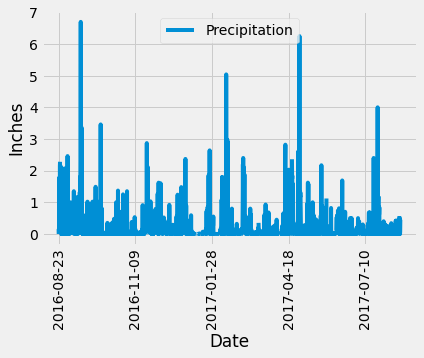

In [46]:
fig = precip_df.plot(x = 'Date', y = 'Precipitation', rot=90)
fig = plt.ylabel('Inches')

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [48]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [49]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.station).count()
print(f"There are {num_stations} unique stations available in this dataset.")

There are 9 unique stations available in this dataset.


In [68]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
tobs_info = session.query(Measurement.station, func.count(Measurement.tobs), Measurement.date).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
most_active_station = tobs_info[0][0]
tobs_info


[('USC00519281', 2772, '2010-01-01'),
 ('USC00519397', 2724, '2010-01-01'),
 ('USC00513117', 2709, '2010-01-01'),
 ('USC00519523', 2669, '2010-01-01'),
 ('USC00516128', 2612, '2010-01-01'),
 ('USC00514830', 2202, '2010-03-01'),
 ('USC00511918', 1979, '2010-01-01'),
 ('USC00517948', 1372, '2010-05-03'),
 ('USC00518838', 511, '2010-01-01')]

In [72]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
data = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station==most_active_station).all()
return_dict = {"Minimum Temperature": data[0][0], "Maximum Temperature": data[0][1], "Average Temperature": data[0][2]}
return_dict

{'Minimum Temperature': 54.0,
 'Maximum Temperature': 85.0,
 'Average Temperature': 71.66378066378067}

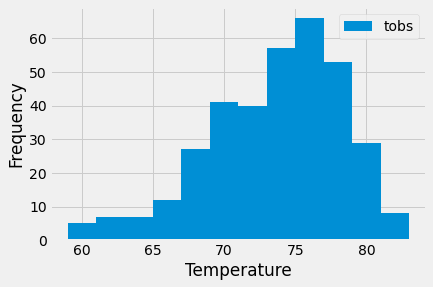

In [79]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data_12month = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station==most_active_station).filter(Measurement.date >= first_date).all()
data_12month_df = pd.DataFrame(data=data_12month, columns=['date','tobs'])
fig = data_12month_df.plot.hist(bins=12)
fig = plt.xlabel("Temperature")

## Bonus Challenge Assignment

In [53]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [54]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [55]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [56]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [57]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [58]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [59]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [60]:
# Plot the daily normals as an area plot with `stacked=False`
